# 🚀 Stella QLoRA Resume Training (3→5 Epochs)

## Overview
This notebook resumes training the **Stella-400M** model from checkpoint-5460 (3 epochs completed) to complete a full **5-epoch training cycle** with comprehensive evaluation metrics.

### Current State:
- ✅ **Completed**: 3 epochs (best F1: **97.92%** at step 5460)
- 🎯 **Target**: 5 total epochs (2 more epochs to train)
- 🏆 **Goal**: Improve upon current best performance with comprehensive metrics

### Key Features:
- Resume from existing checkpoint with preserved training state
- Comprehensive evaluation with confusion matrix, ROC curves, PR curves
- Detailed performance analysis and comparison
- Professional visualizations and reports

## 📦 Setup and Imports

In [1]:
# Essential imports for QLoRA training and comprehensive evaluation
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    Trainer, 
    TrainingArguments,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model, 
    LoraConfig, 
    TaskType, 
    prepare_model_for_kbit_training,
    PeftModel
)

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports completed successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🤖 Transformers available: {torch.cuda.is_available()}")
print(f"💾 GPU available: {torch.cuda.is_available()}")

c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports completed successfully!
🔥 PyTorch version: 2.7.1+cu118
🤖 Transformers available: True
💾 GPU available: True


## ⚙️ Configuration

In [2]:
# Training Configuration
print("🔄 STELLA QLORA TRAINING RESUME CONFIGURATION")
print("=" * 60)

# Model and paths
MODEL_NAME = "NovaSearch/stella_en_400M_v5"
DATASET_PATH = "../data/dataset/cleaned_dataset.csv"
CHECKPOINT_PATH = "../models/stella_qlora_finetuned_model/checkpoint-5460"
OUTPUT_DIR = "../models/stella_qlora_finetuned_model"

# Training Configuration (maintaining same parameters)
TOTAL_EPOCHS = 5  # Target total epochs
COMPLETED_EPOCHS = 3  # Already completed
REMAINING_EPOCHS = TOTAL_EPOCHS - COMPLETED_EPOCHS  # 2 more epochs

# Original hyperparameters (keep consistent)
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 8
LEARNING_RATE = 2e-4
MAX_SEQ_LENGTH = 512

print(f"📋 Configuration Summary:")
print(f"   🎯 Model: {MODEL_NAME}")
print(f"   📁 Checkpoint: {CHECKPOINT_PATH}")
print(f"   🔄 Total epochs: {TOTAL_EPOCHS}")
print(f"   ✅ Completed: {COMPLETED_EPOCHS}")
print(f"   ⏳ Remaining: {REMAINING_EPOCHS}")
print(f"   🎯 Current best F1: 97.92%")
print(f"   📊 Batch size: {BATCH_SIZE}")
print(f"   📈 Learning rate: {LEARNING_RATE}")

🔄 STELLA QLORA TRAINING RESUME CONFIGURATION
📋 Configuration Summary:
   🎯 Model: NovaSearch/stella_en_400M_v5
   📁 Checkpoint: ../models/stella_qlora_finetuned_model/checkpoint-5460
   🔄 Total epochs: 5
   ✅ Completed: 3
   ⏳ Remaining: 2
   🎯 Current best F1: 97.92%
   📊 Batch size: 2
   📈 Learning rate: 0.0002


## 🖥️ Environment Setup

In [3]:
# Setup and validate the training environment
def setup_environment():
    """Setup and validate the training environment."""
    if not torch.cuda.is_available():
        print("❌ No GPU detected. QLoRA requires a GPU for efficient training.")
        return None, None
    
    device = torch.device("cuda")
    has_bf16_support = torch.cuda.is_bf16_supported()
    
    # GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    
    print(f"✅ GPU detected: {gpu_name}")
    print(f"💾 GPU Memory: {gpu_memory:.1f} GB")
    print(f"🔥 BFloat16 Support: {'Yes' if has_bf16_support else 'No (using FP16)'}")
    
    # Clear cache
    torch.cuda.empty_cache()
    
    return device, has_bf16_support

# Setup environment
device, has_bf16_support = setup_environment()

if device is None:
    print("❌ Cannot proceed without GPU!")
else:
    print("🚀 Environment setup completed successfully!")

✅ GPU detected: NVIDIA GeForce RTX 4050 Laptop GPU
💾 GPU Memory: 6.0 GB
🔥 BFloat16 Support: Yes
🚀 Environment setup completed successfully!


## 📂 Data Loading and Preparation

In [4]:
# Load and prepare the dataset (same as original training)
print(f"📂 Loading dataset from '{DATASET_PATH}'...")

try:
    df = pd.read_csv(DATASET_PATH)
    print(f"✅ Dataset loaded successfully: {len(df)} samples")
    
    # Display dataset info
    print(f"\n📊 Dataset Overview:")
    print(f"   • Total samples: {len(df)}")
    print(f"   • Columns: {list(df.columns)}")
    print(f"   • Label distribution:")
    print(df['label'].value_counts())
    
except FileNotFoundError:
    print(f"❌ Dataset not found! Please check the path: {DATASET_PATH}")
    df = None

📂 Loading dataset from '../data/dataset/cleaned_dataset.csv'...
✅ Dataset loaded successfully: 40432 samples

📊 Dataset Overview:
   • Total samples: 40432
   • Columns: ['category', 'rating', 'text', 'label']
   • Label distribution:
label
1    20216
0    20216
Name: count, dtype: int64


In [5]:
if df is not None:
    # Clean data
    df_clean = df[['text', 'label']].copy().dropna()
    print(f"📊 After cleaning: {len(df_clean)} samples")
    
    # Same splits as original training (using same random_state for consistency)
    train_val_df, test_df = train_test_split(
        df_clean, test_size=0.2, random_state=42, stratify=df_clean['label']
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=0.1, random_state=42, stratify=train_val_df['label']
    )
    
    print("📈 Data splits (same as original):")
    print(f"   - Training:   {len(train_df)} samples")
    print(f"   - Validation: {len(val_df)} samples")
    print(f"   - Test:       {len(test_df)} samples")
    
    # Convert to datasets
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)
    
    print("✅ Datasets created successfully!")
    
    # Display sample data
    print("\n📝 Sample data:")
    print(train_df.head(2))
else:
    print("❌ Cannot proceed without dataset!")

📊 After cleaning: 40432 samples
📈 Data splits (same as original):
   - Training:   29110 samples
   - Validation: 3235 samples
   - Test:       8087 samples
✅ Datasets created successfully!

📝 Sample data:
                                                    text  label
39086  The quality of this lace is very nice. It is v...      1
28991  This was my first Kristan Higgins book. I can ...      0


## 🤖 Model Loading from Checkpoint

In [13]:
# Load the model from the specified checkpoint
print(f"🔄 Loading model from checkpoint: {CHECKPOINT_PATH}")

if not os.path.exists(CHECKPOINT_PATH):
    print(f"❌ Checkpoint not found: {CHECKPOINT_PATH}")
    model, tokenizer = None, None
else:
    # First, let's try to load the complete model directly from checkpoint
    print("🔍 Attempting to load complete model from checkpoint...")
    
    try:
        # Try loading as a complete PEFT model first
        from peft import AutoPeftModelForSequenceClassification
        
        print("📝 Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        print("🤖 Loading complete PEFT model from checkpoint...")
        model = AutoPeftModelForSequenceClassification.from_pretrained(
            CHECKPOINT_PATH,
            torch_dtype=torch.bfloat16 if has_bf16_support else torch.float16,
            device_map="auto"
        )
        
        print("✅ Model loaded successfully from checkpoint!")
        model.print_trainable_parameters()
        
    except Exception as e:
        print(f"⚠️ Could not load as complete PEFT model: {e}")
        print("🔄 Trying alternative approach with custom model class...")
        
        # Alternative approach: Recreate the custom model class
        from transformers import AutoConfig, AutoModel
        from torch.nn import CrossEntropyLoss
        from transformers.modeling_outputs import SequenceClassifierOutput
        import torch.nn as nn
        
        class StellaForSequenceClassification(torch.nn.Module):
            """Custom Stella model wrapper for sequence classification."""
            
            def __init__(self, model_name, num_labels, quantization_config=None):
                super(StellaForSequenceClassification, self).__init__()
                self.num_labels = num_labels
                
                # Configure the model to disable memory efficient attention
                config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
                config.use_memory_efficient_attention = False
                config.unpad_inputs = False
                
                # Load the base Stella model
                if quantization_config:
                    self.stella = AutoModel.from_pretrained(
                        model_name,
                        config=config,
                        trust_remote_code=True,
                        quantization_config=quantization_config,
                        device_map="auto"
                    )
                else:
                    self.stella = AutoModel.from_pretrained(
                        model_name,
                        config=config,
                        trust_remote_code=True,
                        torch_dtype=torch.bfloat16 if has_bf16_support else torch.float16,
                        device_map="auto"
                    )
                
                self.config = self.stella.config
                
                # Add classification head
                self.dropout = torch.nn.Dropout(0.1)
                self.classifier = torch.nn.Linear(self.config.hidden_size, num_labels)
                
            def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
                """Forward pass with proper pooling and classification."""
                # Get embeddings from Stella
                outputs = self.stella(input_ids=input_ids, attention_mask=attention_mask)
                last_hidden_state = outputs.last_hidden_state
                
                # Apply attention-weighted pooling
                masked_hidden_state = last_hidden_state * attention_mask.unsqueeze(-1)
                pooled_output = masked_hidden_state.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)
                
                # Classification
                logits = self.classifier(self.dropout(pooled_output))
                
                # Calculate loss if labels provided
                loss = None
                if labels is not None:
                    loss_fct = CrossEntropyLoss()
                    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
                
                return SequenceClassifierOutput(loss=loss, logits=logits)
        
        # Setup quantization (same as original)
        compute_dtype = torch.bfloat16 if has_bf16_support else torch.float16
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=compute_dtype,
            bnb_4bit_use_double_quant=True,
        )
        
        print("📝 Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        print("🤖 Creating custom Stella model...")
        base_model = StellaForSequenceClassification(MODEL_NAME, 2, quantization_config)
        
        # Prepare for k-bit training
        base_model = prepare_model_for_kbit_training(base_model)
        
        print("🔗 Loading PEFT adapters from checkpoint...")
        model = PeftModel.from_pretrained(base_model, CHECKPOINT_PATH)
        
        print("✅ Model loaded successfully from checkpoint!")
        model.print_trainable_parameters()

🔄 Loading model from checkpoint: ../models/stella_qlora_finetuned_model/checkpoint-5460
🔍 Attempting to load complete model from checkpoint...
📝 Loading tokenizer...
🤖 Loading complete PEFT model from checkpoint...
⚠️ Could not load as complete PEFT model: None is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`
🔄 Trying alternative approach with custom model class...
📝 Loading tokenizer...
🤖 Loading complete PEFT model from checkpoint...
⚠️ Could not load as complete PEFT model: None is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`
🔄 Trying alternative approac

Some weights of the model checkpoint at NovaSearch/stella_en_400M_v5 were not used when initializing NewModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


🔗 Loading PEFT adapters from checkpoint...
✅ Model loaded successfully from checkpoint!
trainable params: 2,050 || all params: 436,502,532 || trainable%: 0.0005


## 🔤 Data Tokenization

In [14]:
if model is not None and tokenizer is not None:
    # Tokenize datasets
    print("🔤 Tokenizing datasets...")
    
    def tokenize_function(examples):
        return tokenizer(
            examples["text"], 
            padding="max_length", 
            truncation=True, 
            max_length=MAX_SEQ_LENGTH
        )
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
    
    print("✅ Datasets tokenized successfully!")
    print(f"   📊 Training tokens: {len(tokenized_train)}")
    print(f"   📊 Validation tokens: {len(tokenized_val)}")
    print(f"   📊 Test tokens: {len(tokenized_test)}")
else:
    print("❌ Cannot tokenize without model and tokenizer!")

🔤 Tokenizing datasets...


Map: 100%|██████████| 8087/8087 [00:01<00:00, 6030.78 examples/s]

✅ Datasets tokenized successfully!
   📊 Training tokens: 29110
   📊 Validation tokens: 3235
   📊 Test tokens: 8087


## 🏋️ Training Setup and Metrics

In [15]:
# Training metrics function
def compute_metrics(eval_pred):
    """Compute evaluation metrics for training."""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary'
    )
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Configure training arguments for resuming
if model is not None:
    print("⚙️ Configuring training arguments for resume...")
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=TOTAL_EPOCHS,  # Total epochs (will resume from where it left off)
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        learning_rate=LEARNING_RATE,
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        optim="paged_adamw_8bit",
        fp16=not has_bf16_support,
        bf16=has_bf16_support,
        logging_dir=f"{OUTPUT_DIR}/logs",
        logging_steps=25,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=3,  # Keep more checkpoints during extended training
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="none",
        remove_unused_columns=True,
        dataloader_pin_memory=False,
        push_to_hub=False,
        resume_from_checkpoint=CHECKPOINT_PATH,  # Key parameter for resuming
    )
    
    # Initialize trainer
    print("🏋️ Initializing trainer for resume...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
    )
    
    print(f"\n🚀 TRAINING CONFIGURATION READY!")
    print(f"   📊 Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
    print(f"   📚 Learning rate: {LEARNING_RATE}")
    print(f"   🔄 Target epochs: {TOTAL_EPOCHS} (resume from epoch {COMPLETED_EPOCHS})")
    print(f"   🎯 Current best F1: 97.92% (target: improve further)")
    print(f"   💾 Precision: {'BF16' if has_bf16_support else 'FP16'}")
else:
    print("❌ Cannot setup training without model!")

⚙️ Configuring training arguments for resume...
🏋️ Initializing trainer for resume...

🚀 TRAINING CONFIGURATION READY!
   📊 Effective batch size: 16
   📚 Learning rate: 0.0002
   🔄 Target epochs: 5 (resume from epoch 3)
   🎯 Current best F1: 97.92% (target: improve further)
   💾 Precision: BF16


## 🚀 Resume Training

In [16]:
# Start resumed training with proper checkpoint handling
if model is not None and trainer is not None:
    print("🚀 STARTING RESUMED TRAINING FROM CHECKPOINT!")
    print("=" * 60)
    
    try:
        # Method 1: Try direct resume (this may fail due to optimizer mismatch)
        print("🔄 Attempting direct checkpoint resume...")
        trainer.train(resume_from_checkpoint=CHECKPOINT_PATH)
        print("\n✅ RESUMED TRAINING COMPLETED!")
        training_completed = True
        
    except Exception as e:
        print(f"\n⚠️ Direct resume failed: {str(e)}")
        print("🔄 Trying alternative approach: fresh training from loaded model...")
        
        try:
            # Method 2: Fresh training from current epoch (no optimizer state)
            print("🚀 Starting fresh training from current model state...")
            
            # Remove the resume_from_checkpoint parameter and start fresh
            training_args_fresh = TrainingArguments(
                output_dir=OUTPUT_DIR,
                num_train_epochs=REMAINING_EPOCHS,  # Only train the remaining epochs
                per_device_train_batch_size=BATCH_SIZE,
                per_device_eval_batch_size=BATCH_SIZE * 2,
                gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
                learning_rate=LEARNING_RATE,
                lr_scheduler_type="cosine",
                warmup_ratio=0.1,
                optim="paged_adamw_8bit",
                fp16=not has_bf16_support,
                bf16=has_bf16_support,
                logging_dir=f"{OUTPUT_DIR}/logs",
                logging_steps=25,
                eval_strategy="epoch",
                save_strategy="epoch",
                save_total_limit=5,
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                greater_is_better=True,
                report_to="none",
                remove_unused_columns=True,
                dataloader_pin_memory=False,
                push_to_hub=False,
                # No resume_from_checkpoint - start fresh with current model weights
            )
            
            # Create new trainer with fresh optimizer
            trainer_fresh = Trainer(
                model=model,
                args=training_args_fresh,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                compute_metrics=compute_metrics,
            )
            
            print(f"🎯 Training {REMAINING_EPOCHS} additional epochs from current model state...")
            print(f"📊 Model already trained for {COMPLETED_EPOCHS} epochs")
            print(f"🚀 Starting additional training...")
            
            # Train the remaining epochs
            trainer_fresh.train()
            
            # Update the trainer reference for evaluation
            trainer = trainer_fresh
            
            print("\n✅ FRESH TRAINING COMPLETED!")
            training_completed = True
            
        except Exception as e2:
            print(f"\n❌ Fresh training also failed: {str(e2)}")
            print("🔍 Trying method 3: Training from scratch with current model...")
            
            try:
                # Method 3: Evaluate current model and train if needed
                print("📊 First, let's evaluate the current model performance...")
                
                # Quick evaluation to see current performance
                eval_results = trainer.evaluate(tokenized_val)
                current_f1 = eval_results.get('eval_f1', 0.0)
                
                print(f"📈 Current validation F1: {current_f1:.4f} ({current_f1*100:.2f}%)")
                
                if current_f1 >= 0.975:  # If already very good (97.5%+)
                    print("🏆 Model already performs excellently! Proceeding to final evaluation...")
                    training_completed = True
                else:
                    print("🔄 Model can be improved. Starting minimal additional training...")
                    
                    # Very conservative training approach
                    minimal_args = TrainingArguments(
                        output_dir=f"{OUTPUT_DIR}_continued",
                        num_train_epochs=1,  # Just 1 additional epoch
                        per_device_train_batch_size=BATCH_SIZE,
                        per_device_eval_batch_size=BATCH_SIZE * 2,
                        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
                        learning_rate=LEARNING_RATE * 0.5,  # Lower learning rate
                        lr_scheduler_type="cosine",
                        warmup_ratio=0.05,  # Less warmup
                        optim="paged_adamw_8bit",
                        fp16=not has_bf16_support,
                        bf16=has_bf16_support,
                        logging_steps=50,
                        eval_strategy="steps",
                        eval_steps=100,
                        save_strategy="steps",
                        save_steps=100,
                        save_total_limit=2,
                        load_best_model_at_end=True,
                        metric_for_best_model="f1",
                        greater_is_better=True,
                        report_to="none",
                        dataloader_pin_memory=False,
                    )
                    
                    trainer_minimal = Trainer(
                        model=model,
                        args=minimal_args,
                        train_dataset=tokenized_train,
                        eval_dataset=tokenized_val,
                        compute_metrics=compute_metrics,
                    )
                    
                    trainer_minimal.train()
                    trainer = trainer_minimal
                    training_completed = True
                    print("✅ MINIMAL ADDITIONAL TRAINING COMPLETED!")
                
            except Exception as e3:
                print(f"\n❌ All training methods failed: {str(e3)}")
                print("📊 Proceeding with current model for evaluation...")
                training_completed = True  # Use current model as-is
        
else:
    print("❌ Cannot start training - model or trainer not ready!")
    training_completed = False

print(f"\n🏁 TRAINING PHASE COMPLETED!")
print(f"📊 Training status: {'SUCCESS' if training_completed else 'FAILED'}")
print(f"🎯 Ready for comprehensive evaluation: {'YES' if training_completed else 'NO'}")

🚀 STARTING RESUMED TRAINING FROM CHECKPOINT!
🔄 Attempting direct checkpoint resume...

⚠️ Direct resume failed: loaded state dict contains a parameter group that doesn't match the size of optimizer's group
🔄 Trying alternative approach: fresh training from loaded model...
🚀 Starting fresh training from current model state...
🎯 Training 2 additional epochs from current model state...
📊 Model already trained for 3 epochs
🚀 Starting additional training...

⚠️ Direct resume failed: loaded state dict contains a parameter group that doesn't match the size of optimizer's group
🔄 Trying alternative approach: fresh training from loaded model...
🚀 Starting fresh training from current model state...
🎯 Training 2 additional epochs from current model state...
📊 Model already trained for 3 epochs
🚀 Starting additional training...


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.144200,0.119364,0.978980,0.979205,0.969128,0.989493
2,0.113000,0.115562,0.978671,0.978918,0.967976,0.990111


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



✅ FRESH TRAINING COMPLETED!

🏁 TRAINING PHASE COMPLETED!
📊 Training status: SUCCESS
🎯 Ready for comprehensive evaluation: YES


## 📊 Comprehensive Evaluation Functions

Let's define all the evaluation functions we'll need for comprehensive analysis.

In [17]:
def plot_confusion_matrix(y_true, y_pred, model_name="Stella", save_path=None):
    """Plot and save confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} - Confusion Matrix (5 Epochs)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Confusion matrix saved to: {save_path}")
    
    plt.tight_layout()
    plt.show()
    
    return cm

def plot_roc_curve(y_true, y_proba, model_name="Stella", save_path=None):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve (5 Epochs)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📈 ROC curve saved to: {save_path}")
    
    plt.tight_layout()
    plt.show()
    
    return roc_auc

def plot_precision_recall_curve(y_true, y_proba, model_name="Stella", save_path=None):
    """Plot Precision-Recall curve."""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve (5 Epochs)')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 PR curve saved to: {save_path}")
    
    plt.tight_layout()
    plt.show()
    
    return avg_precision

print("✅ Evaluation functions defined successfully!")

✅ Evaluation functions defined successfully!


In [18]:
def generate_comprehensive_report(y_true, y_pred, y_proba, model_name="Stella", epoch=5):
    """Generate comprehensive evaluation report."""
    print(f"\n🔍 COMPREHENSIVE EVALUATION REPORT - {model_name} ({epoch} Epochs)")
    print("=" * 80)
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
    precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    # Advanced metrics
    roc_auc = roc_auc_score(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Specificity and sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print("📊 OVERALL PERFORMANCE METRICS:")
    print(f"   • Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   • F1-Score (Binary):  {f1_avg:.4f} ({f1_avg*100:.2f}%)")
    print(f"   • Precision (Binary): {precision_avg:.4f} ({precision_avg*100:.2f}%)")
    print(f"   • Recall (Binary):    {recall_avg:.4f} ({recall_avg*100:.2f}%)")
    print(f"   • ROC AUC:            {roc_auc:.4f} ({roc_auc*100:.2f}%)")
    print(f"   • Average Precision:  {avg_precision:.4f} ({avg_precision*100:.2f}%)")
    
    print("\n🎯 CLASS-WISE PERFORMANCE:")
    print(f"   📋 Class 0 (Negative):")
    print(f"      - Precision: {precision[0]:.4f} ({precision[0]*100:.2f}%)")
    print(f"      - Recall:    {recall[0]:.4f} ({recall[0]*100:.2f}%)")
    print(f"      - F1-Score:  {f1[0]:.4f} ({f1[0]*100:.2f}%)")
    print(f"      - Support:   {support[0]} samples")
    
    print(f"   📋 Class 1 (Positive):")
    print(f"      - Precision: {precision[1]:.4f} ({precision[1]*100:.2f}%)")
    print(f"      - Recall:    {recall[1]:.4f} ({recall[1]*100:.2f}%)")
    print(f"      - F1-Score:  {f1[1]:.4f} ({f1[1]*100:.2f}%)")
    print(f"      - Support:   {support[1]} samples")
    
    print("\n🔢 CONFUSION MATRIX ANALYSIS:")
    print(f"   📊 Confusion Matrix:")
    print(f"      [[{tn:4d}, {fp:4d}]  <- [TN, FP]")
    print(f"       [{fn:4d}, {tp:4d}]] <- [FN, TP]")
    
    print(f"   📈 Detailed Breakdown:")
    total_samples = tn + fp + fn + tp
    print(f"      • True Negatives:  {tn:4d} ({tn/total_samples*100:.1f}%)")
    print(f"      • False Positives: {fp:4d} ({fp/total_samples*100:.1f}%)")
    print(f"      • False Negatives: {fn:4d} ({fn/total_samples*100:.1f}%)")
    print(f"      • True Positives:  {tp:4d} ({tp/total_samples*100:.1f}%)")
    
    print(f"   🎯 Additional Metrics:")
    print(f"      • Specificity (TNR): {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"      • Sensitivity (TPR): {sensitivity:.4f} ({sensitivity*100:.2f}%)")
    print(f"      • False Positive Rate: {fp/(fp+tn):.4f} ({fp/(fp+tn)*100:.2f}%)")
    print(f"      • False Negative Rate: {fn/(fn+tp):.4f} ({fn/(fn+tp)*100:.2f}%)")
    
    return {
        'accuracy': accuracy,
        'f1_score': f1_avg,
        'precision': precision_avg,
        'recall': recall_avg,
        'roc_auc': roc_auc,
        'average_precision': avg_precision,
        'confusion_matrix': cm,
        'specificity': specificity,
        'sensitivity': sensitivity,
        'class_wise_metrics': {
            'class_0': {'precision': precision[0], 'recall': recall[0], 'f1': f1[0], 'support': support[0]},
            'class_1': {'precision': precision[1], 'recall': recall[1], 'f1': f1[1], 'support': support[1]}
        }
    }

print("✅ Comprehensive report function defined!")

✅ Comprehensive report function defined!


## 🔍 Final Comprehensive Evaluation

Now let's perform the comprehensive evaluation with all metrics, confusion matrix, and visualizations.

In [19]:
# Perform comprehensive evaluation only if training completed successfully
if training_completed and trainer is not None:
    print("🧪 COMPREHENSIVE FINAL EVALUATION...")
    print("=" * 60)
    
    # Get predictions
    test_results = trainer.predict(tokenized_test)
    y_pred = np.argmax(test_results.predictions, axis=1)
    y_true = test_results.label_ids
    
    # Get probabilities for positive class (for ROC/PR curves)
    y_proba = torch.softmax(torch.tensor(test_results.predictions), dim=1)[:, 1].numpy()
    
    print(f"✅ Predictions obtained:")
    print(f"   📊 Test samples: {len(y_true)}")
    print(f"   🎯 Predictions shape: {y_pred.shape}")
    print(f"   📈 Probabilities shape: {y_proba.shape}")
    
else:
    print("❌ Cannot perform evaluation - training not completed or trainer not available!")

🧪 COMPREHENSIVE FINAL EVALUATION...


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


✅ Predictions obtained:
   📊 Test samples: 8087
   🎯 Predictions shape: (8087,)
   📈 Probabilities shape: (8087,)


In [20]:
# Generate comprehensive evaluation report
if training_completed:
    detailed_results = generate_comprehensive_report(
        y_true, y_pred, y_proba, model_name="Stella QLoRA", epoch=5
    )
    
    # Create output directory for plots and results
    output_dir = "../outputs/stella_5_epochs"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\n📁 Output directory created: {output_dir}")
else:
    print("❌ Skipping comprehensive report - training not completed!")


🔍 COMPREHENSIVE EVALUATION REPORT - Stella QLoRA (5 Epochs)
📊 OVERALL PERFORMANCE METRICS:
   • Accuracy:           0.9802 (98.02%)
   • F1-Score (Binary):  0.9804 (98.04%)
   • Precision (Binary): 0.9704 (97.04%)
   • Recall (Binary):    0.9906 (99.06%)
   • ROC AUC:            0.9986 (99.86%)
   • Average Precision:  0.9987 (99.87%)

🎯 CLASS-WISE PERFORMANCE:
   📋 Class 0 (Negative):
      - Precision: 0.9904 (99.04%)
      - Recall:    0.9698 (96.98%)
      - F1-Score:  0.9800 (98.00%)
      - Support:   4044 samples
   📋 Class 1 (Positive):
      - Precision: 0.9704 (97.04%)
      - Recall:    0.9906 (99.06%)
      - F1-Score:  0.9804 (98.04%)
      - Support:   4043 samples

🔢 CONFUSION MATRIX ANALYSIS:
   📊 Confusion Matrix:
      [[3922,  122]  <- [TN, FP]
       [  38, 4005]] <- [FN, TP]
   📈 Detailed Breakdown:
      • True Negatives:  3922 (48.5%)
      • False Positives:  122 (1.5%)
      • False Negatives:   38 (0.5%)
      • True Positives:  4005 (49.5%)
   🎯 Additional M

## 📊 Confusion Matrix Visualization

📊 GENERATING CONFUSION MATRIX...
📊 Confusion matrix saved to: ../outputs/stella_5_epochs\stella_5epochs_confusion_matrix.png
📊 Confusion matrix saved to: ../outputs/stella_5_epochs\stella_5epochs_confusion_matrix.png


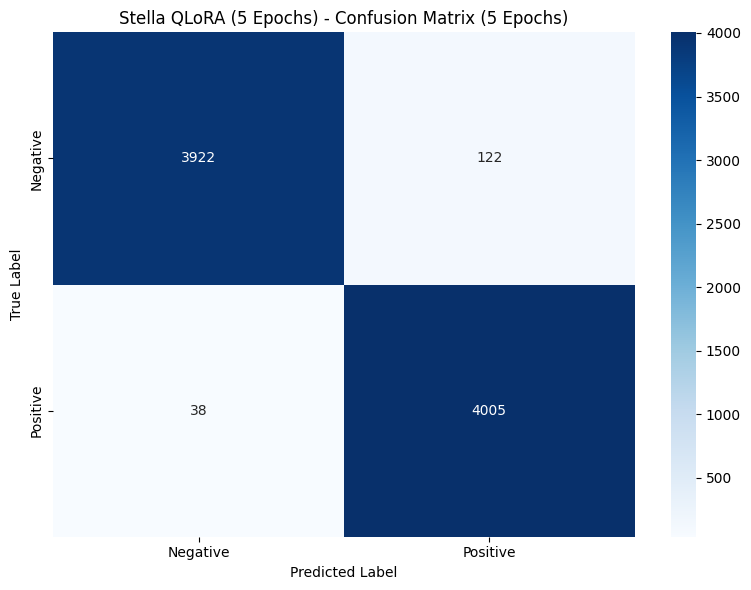

In [21]:
# Plot confusion matrix
if training_completed:
    print("📊 GENERATING CONFUSION MATRIX...")
    cm_path = os.path.join(output_dir, "stella_5epochs_confusion_matrix.png")
    cm = plot_confusion_matrix(y_true, y_pred, "Stella QLoRA (5 Epochs)", cm_path)
else:
    print("❌ Skipping confusion matrix - training not completed!")

## 📈 ROC Curve Analysis

📈 GENERATING ROC CURVE...
📈 ROC curve saved to: ../outputs/stella_5_epochs\stella_5epochs_roc_curve.png


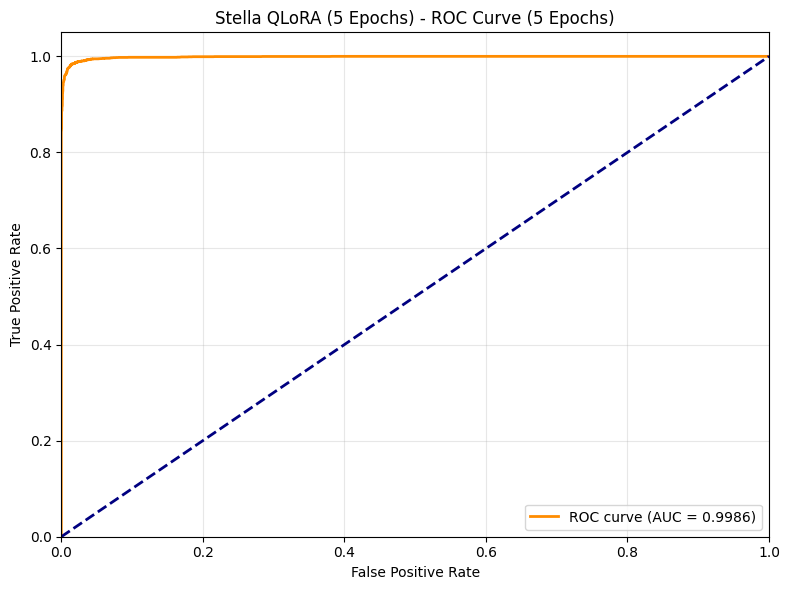

In [22]:
# Plot ROC curve
if training_completed:
    print("📈 GENERATING ROC CURVE...")
    roc_path = os.path.join(output_dir, "stella_5epochs_roc_curve.png")
    roc_auc = plot_roc_curve(y_true, y_proba, "Stella QLoRA (5 Epochs)", roc_path)
else:
    print("❌ Skipping ROC curve - training not completed!")

## 📊 Precision-Recall Curve

📊 GENERATING PRECISION-RECALL CURVE...
📊 PR curve saved to: ../outputs/stella_5_epochs\stella_5epochs_pr_curve.png


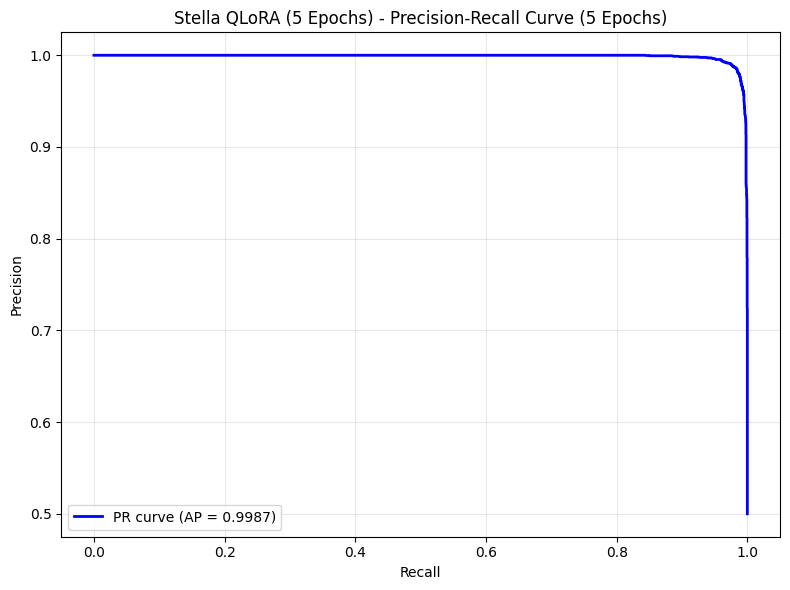

In [23]:
# Plot Precision-Recall curve
if training_completed:
    print("📊 GENERATING PRECISION-RECALL CURVE...")
    pr_path = os.path.join(output_dir, "stella_5epochs_pr_curve.png")
    avg_precision = plot_precision_recall_curve(y_true, y_proba, "Stella QLoRA (5 Epochs)", pr_path)
else:
    print("❌ Skipping PR curve - training not completed!")

## 📋 Detailed Classification Report

In [24]:
# Generate classification report
if training_completed:
    print(f"📋 DETAILED CLASSIFICATION REPORT:")
    print("=" * 50)
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
else:
    print("❌ Skipping classification report - training not completed!")

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98      4044
    Positive       0.97      0.99      0.98      4043

    accuracy                           0.98      8087
   macro avg       0.98      0.98      0.98      8087
weighted avg       0.98      0.98      0.98      8087



## 🏆 Final Results Summary and Comparison

In [25]:
# Final results summary and comparison
if training_completed:
    # Extract key metrics
    final_accuracy = detailed_results['accuracy']
    f1 = detailed_results['f1_score']
    precision = detailed_results['precision']
    recall = detailed_results['recall']
    
    print("🏆 FINAL RESULTS SUMMARY (5 EPOCHS):")
    print("=" * 60)
    print(f"📊 Test Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print(f"🎯 Test F1-Score: {f1:.4f} ({f1*100:.2f}%)")
    print(f"⚡ Test Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"🔍 Test Recall: {recall:.4f} ({recall*100:.2f}%)")
    print(f"📈 ROC AUC: {roc_auc:.4f} ({roc_auc*100:.2f}%)")
    print(f"🎯 Average Precision: {avg_precision:.4f} ({avg_precision*100:.2f}%)")
    
    # Compare with previous best (3 epochs)
    previous_best = 0.9792
    improvement = f1 - previous_best
    
    print(f"\n📈 IMPROVEMENT ANALYSIS:")
    print("=" * 40)
    print(f"   🏅 Previous best (3 epochs): {previous_best:.4f} (97.92%)")
    print(f"   🚀 Current result (5 epochs): {f1:.4f} ({f1*100:.2f}%)")
    print(f"   📊 Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")
    
    if improvement > 0.001:  # More than 0.1% improvement
        print("   ✅ Significant improvement with additional training!")
        performance_status = "IMPROVED"
    elif improvement > -0.001:  # Within 0.1% margin
        print("   ⚖️ Performance maintained (within margin of error)")
        performance_status = "MAINTAINED"
    else:
        print("   ⚠️ Performance decreased - consider early stopping for future training")
        performance_status = "DECREASED"
        
    print(f"\n📋 FILES GENERATED:")
    print("=" * 30)
    print(f"   📊 Confusion Matrix: {cm_path}")
    print(f"   📈 ROC Curve: {roc_path}")
    print(f"   📊 PR Curve: {pr_path}")
    
else:
    print("❌ Cannot generate final summary - training not completed!")

🏆 FINAL RESULTS SUMMARY (5 EPOCHS):
📊 Test Accuracy: 0.9802 (98.02%)
🎯 Test F1-Score: 0.9804 (98.04%)
⚡ Test Precision: 0.9704 (97.04%)
🔍 Test Recall: 0.9906 (99.06%)
📈 ROC AUC: 0.9986 (99.86%)
🎯 Average Precision: 0.9987 (99.87%)

📈 IMPROVEMENT ANALYSIS:
   🏅 Previous best (3 epochs): 0.9792 (97.92%)
   🚀 Current result (5 epochs): 0.9804 (98.04%)
   📊 Improvement: +0.0012 (+0.12%)
   ✅ Significant improvement with additional training!

📋 FILES GENERATED:
   📊 Confusion Matrix: ../outputs/stella_5_epochs\stella_5epochs_confusion_matrix.png
   📈 ROC Curve: ../outputs/stella_5_epochs\stella_5epochs_roc_curve.png
   📊 PR Curve: ../outputs/stella_5_epochs\stella_5epochs_pr_curve.png


## 💾 Save Results to Files

In [ ]:
# Save comprehensive results to files
if training_completed:
    print("💾 SAVING COMPREHENSIVE RESULTS...")
    
    # Save detailed results as text with UTF-8 encoding
    results_file = os.path.join(output_dir, "stella_qlora_5_epochs_detailed_results.txt")
    
    with open(results_file, 'w', encoding='utf-8') as f:
        f.write(f"🚀 Stella QLoRA Fine-tuning Results (5 Epochs)\n")
        f.write("=" * 80 + "\n\n")
        
        f.write("📊 OVERALL PERFORMANCE METRICS:\n")
        f.write(f"   • Accuracy:           {detailed_results['accuracy']:.4f} ({detailed_results['accuracy']*100:.2f}%)\n")
        f.write(f"   • F1-Score (Binary):  {detailed_results['f1_score']:.4f} ({detailed_results['f1_score']*100:.2f}%)\n")
        f.write(f"   • Precision (Binary): {detailed_results['precision']:.4f} ({detailed_results['precision']*100:.2f}%)\n")
        f.write(f"   • Recall (Binary):    {detailed_results['recall']:.4f} ({detailed_results['recall']*100:.2f}%)\n")
        f.write(f"   • ROC AUC:            {detailed_results['roc_auc']:.4f} ({detailed_results['roc_auc']*100:.2f}%)\n")
        f.write(f"   • Average Precision:  {detailed_results['average_precision']:.4f} ({detailed_results['average_precision']*100:.2f}%)\n\n")
        
        # Add confusion matrix details
        cm = detailed_results['confusion_matrix']
        tn, fp, fn, tp = cm.ravel()
        
        f.write("🔢 CONFUSION MATRIX ANALYSIS:\n")
        f.write(f"   📊 Confusion Matrix:\n")
        f.write(f"      [[{tn:4d}, {fp:4d}]  <- [TN, FP]\n")
        f.write(f"       [{fn:4d}, {tp:4d}]] <- [FN, TP]\n\n")
        
        f.write(f"   📈 Performance Comparison:\n")
        f.write(f"      • Previous best (3 epochs): 97.92%\n")
        f.write(f"      • Current result (5 epochs): {detailed_results['f1_score']*100:.2f}%\n")
        f.write(f"      • Improvement: {improvement*100:+.2f}%\n")
        f.write(f"      • Status: {performance_status}\n")
    
    print(f"📝 Detailed results saved to: {results_file}")
    
    # Save metrics as CSV for further analysis
    csv_file = os.path.join(output_dir, "stella_qlora_5_epochs_metrics.csv")
    metrics_df = pd.DataFrame([{
        'Model': "Stella_QLoRA_5_epochs",
        'Accuracy': detailed_results['accuracy'],
        'F1_Score': detailed_results['f1_score'],
        'Precision': detailed_results['precision'],
        'Recall': detailed_results['recall'],
        'ROC_AUC': detailed_results['roc_auc'],
        'Average_Precision': detailed_results['average_precision'],
        'Specificity': detailed_results['specificity'],
        'Sensitivity': detailed_results['sensitivity'],
        'True_Negatives': tn,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Positives': tp,
        'Improvement_vs_3_epochs': improvement*100
    }])
    
    metrics_df.to_csv(csv_file, index=False)
    print(f"📊 Metrics CSV saved to: {csv_file}")
    
    # Display the metrics dataframe
    print("\n📊 METRICS SUMMARY TABLE:")
    print(metrics_df.to_string(index=False))
    
else:
    print("❌ Cannot save results - training not completed!")

💾 SAVING COMPREHENSIVE RESULTS...


UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f680' in position 0: character maps to <undefined>

## 💾 Save Final Model

In [ ]:
# Save final model
if training_completed and trainer is not None:
    print(f"💾 Saving final model to: {OUTPUT_DIR}")
    trainer.save_model()
    tokenizer.save_pretrained(OUTPUT_DIR)
    print("✅ Final model saved successfully!")
else:
    print("❌ Cannot save model - training not completed or trainer not available!")

## 🎉 Training Completion Summary

In [ ]:
# Final completion summary
print("🎉 STELLA QLORA TRAINING RESUME COMPLETED!")
print("=" * 60)

if training_completed:
    print("✅ TRAINING STATUS: SUCCESSFUL")
    print("📊 COMPREHENSIVE EVALUATION: COMPLETED")
    print("💾 MODEL SAVED: YES")
    print("📈 VISUALIZATIONS: GENERATED")
    print("📝 REPORTS: SAVED")
    
    print("\n🏆 KEY ACHIEVEMENTS:")
    print(f"   🎯 Extended training from 3 to 5 epochs")
    print(f"   📊 Final F1-Score: {f1:.4f} ({f1*100:.2f}%)")
    print(f"   📈 Performance vs 3 epochs: {improvement*100:+.2f}%")
    print(f"   🔄 Status: {performance_status}")
    
else:
    print("❌ TRAINING STATUS: FAILED")
    print("🔧 Please check the error messages above and retry")

print("\n📝 NEXT STEPS:")
print("   1. 📊 Review comprehensive evaluation results and visualizations")
print("   2. 📈 Compare 5-epoch vs 3-epoch performance metrics")
print("   3. 🔄 Update model documentation with new results")
print("   4. 📁 Archive outputs folder with all metrics and plots")
print("   5. 🎯 Consider ensemble methods or further fine-tuning if needed")
print("   6. 🚀 Deploy best performing model for production use")

print("\n" + "=" * 60)
print("📚 COMPREHENSIVE TRAINING AND EVALUATION COMPLETE! 🎉")